# Belgian production network model

## Prototyping

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from covid19model.data.economic_parameters import get_economic_parameters
from covid19model.models.economic_utils import *

### Load economic parameters

In [4]:
pars = get_economic_parameters()

### Testing of demand functions

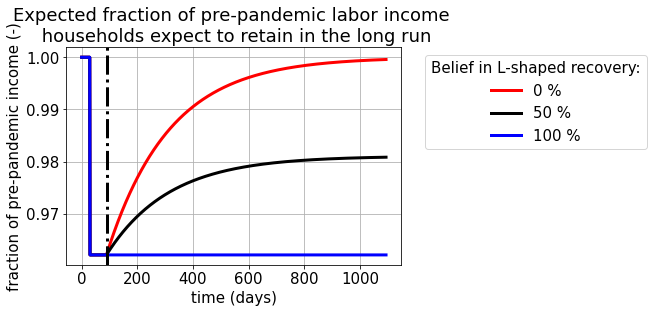

In [294]:
rho = 1-(1-0.6)/90 # recovery time constant
L = 0.2 # fraction of population expecting L-shaped recovery

t_start_lockdown = 30
t_end_lockdown = 30+60
t_end_pandemic = 30+60+365
simtime = 365*3

zeta_previous = 1

fig,ax = plt.subplots()

color=['red','black','blue']
i=0
for L in [0,0.5,1]:
    zeta=[]
    epsilon = np.empty(shape=[63,simtime])
    for time in np.arange(simtime):
        zeta.append(household_income_expectations(time,zeta_previous,t_start_lockdown,t_end_lockdown,pars['l_0'],sum((1-pars['l_s'])*pars['l_0']),rho,L))
        zeta_previous = zeta[-1]
        epsilon[:,time] = list(household_demand_shock(time,t_start_lockdown,t_end_lockdown,t_end_pandemic,pars['c_s'],pars['on_site']))

    ax.plot(np.arange(simtime),zeta,color=color[i])
    i=i+1
    
ax.axvline(t_end_lockdown,color='black',ls='-.')
ax.set_title('Expected fraction of pre-pandemic labor income \n households expect to retain in the long run')
ax.set_xlabel('time (days)')
ax.set_ylabel('fraction of pre-pandemic income (-)')
lgd=ax.legend(['0 %','50 %', '100 %'],bbox_to_anchor=(1.05, 1), loc='upper left',title='Belief in L-shaped recovery:')
ax.grid('on')
fig.savefig('l_p.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

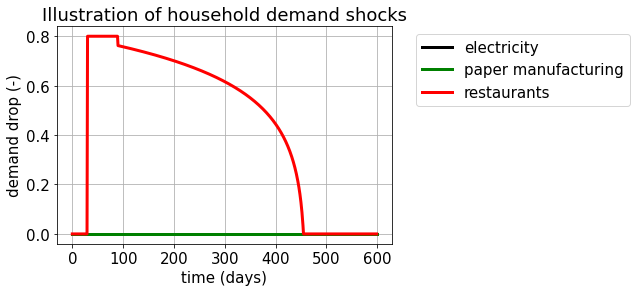

In [295]:
fig,ax = plt.subplots()
plottime = 600
ax.plot(np.arange(plottime),epsilon[23,:plottime],color='black')
ax.plot(np.arange(plottime),epsilon[7,:plottime],color='green')
ax.plot(np.arange(plottime),epsilon[-28,:plottime],color='red')
ax.plot()
ax.plot()
ax.set_title('Illustration of household demand shocks')
ax.set_xlabel('time (days)')
ax.set_ylabel('demand drop (-)')
lgd=ax.legend(['electricity','paper manufacturing','restaurants'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')
fig.savefig('demand_shocks.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

### Testing of full model

In [304]:
# Parameters
# ----------
rho = 1-(1-0.6)/90 # recovery time constant
L = 0 # fraction of population expecting L-shaped recovery
delta_S = 0.5
m = sum(pars['c_0'])/sum(pars['l_0'])
tau = 10
b = 0
gamma_F = 1/7
gamma_H = 1/30

# Timing
# ------
t_start_lockdown = 30
t_end_lockdown = 30+60
t_end_pandemic = 30+60+365
simtime = 500

# Initialisation
# --------------
theta_0 = pars['c_0']/sum(pars['c_0'])
zeta_previous = 1
c_total_previous = sum(pars['c_0']) # Total household demand under business-as-usual
d_t_previous = pars['x_0'] # Demand = Output at start simulation
S_t = pars['S_0']

c_t_array = np.expand_dims(pars['c_0'],axis=1)
O_t_array = np.expand_dims(pars['O_j'],axis=1)
S_t_array = np.expand_dims(np.sum(pars['S_0'],axis=1),axis=1)
d_t_array = np.expand_dims(pars['x_0'],axis=1)
x_t_array = np.expand_dims(pars['x_0'],axis=1)
f_t_array = np.expand_dims(pars['f_0'],axis=1)
l_t = pars['l_0']
l_t_array = np.expand_dims(pars['l_0'],axis=1)

# Simulation loop
# ---------------
for time in np.arange(1,simtime):
    
    # Demand and supply shocks
    # ------------------------
    # Labor
    epsilon_S = labor_supply_shock(time,t_start_lockdown,t_end_lockdown,pars['l_s'])
    # Household demand
    epsilon_D = household_demand_shock(time,t_start_lockdown,t_end_lockdown,t_end_pandemic,pars['c_s'],pars['on_site'])
    # Other demand
    if time < t_start_lockdown:
        f_t = pars['f_0']
    elif ((time >= t_start_lockdown) & (time < t_end_lockdown)):
        f_t = pars['f_0']*(1-pars['f_s'])
    else:
        f_t = pars['f_0']

    # Government intervention
    # -----------------------
    l_t_star = labor_compensation_intervention(time, t_start_lockdown, t_end_pandemic, l_t, pars['l_0'], b)

    # Productive capacity
    # -------------------
    x_t_cap = calc_labor_restriction(pars['x_0'],pars['l_0'],l_t)

    # Input bottlenecks
    # -----------------
    x_t_inp = calc_input_restriction(S_t,pars['A'],pars['C'])

    # Total consumer demand
    # ---------------------

    # Compute preference vector
    theta = household_preference_shock(epsilon_D, theta_0)
    # Compute aggregate demand shock
    epsilon_t = aggregate_demand_shock(epsilon_D, theta_0, delta_S, rho)
    # Compute expected long term labor income (Eq. 22, 23)
    zeta = household_income_expectations(time,zeta_previous,t_start_lockdown,t_end_lockdown,pars['l_0'],sum((1-pars['l_s'])*pars['l_0']),rho,L)
    l_p = zeta*sum(pars['l_0'])
    # Compute total consumer demand (per sector)
    c_t = theta*calc_household_demand(c_total_previous,l_t_star,l_p,epsilon_t,rho,m)
    c_t_array = np.append(c_t_array, np.expand_dims(c_t,axis=1), axis = 1)

    # Intermediate demand
    # -------------------
    O = calc_intermediate_demand(d_t_previous,S_t,pars['A'],pars['S_0'],tau)
    O_t_array = np.append(O_t_array,np.expand_dims(np.sum(O,axis=1),axis=1),axis=1)

    # Total demand
    # ------------
    d_t = calc_total_demand(O,c_t,f_t)
    d_t_array = np.append(d_t_array, np.expand_dims(d_t,axis=1), axis=1)

    # Leontief production function
    # ----------------------------
    x_t = leontief(x_t_cap, x_t_inp, d_t)
    x_t_array = np.append(x_t_array, np.expand_dims(x_t,axis=1), axis=1)
    
    # Rationing
    # ---------
    O,c_t,f_t = rationing(x_t,d_t,O,c_t,f_t)
    f_t_array = np.append(f_t_array, np.expand_dims(f_t,axis=1), axis = 1)
    
    # Update inventories
    # ------------------
    S_t = inventory_updating(S_t,O,x_t,pars['A'])
    S_t_array = np.append(S_t_array, np.expand_dims(np.sum(S_t,axis=1),axis=1), axis=1)
    
    # Hire/fire workers
    # -----------------
    l_t = hiring_firing(l_t, pars['l_0'], pars['x_0'], x_t_inp, x_t_cap, d_t, gamma_F, gamma_H, epsilon_S)
    l_t_array = np.append(l_t_array, np.expand_dims(l_t,axis=1), axis=1)
    
    # Update other states
    # -------------------
    c_total_previous = sum(theta*calc_household_demand(c_total_previous,l_t_star,l_p,epsilon_t,rho,m))
    d_t_previous = d_t
    zeta_previous = zeta

[autoreload of covid19model.models.models failed: Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


TypeError: labor_supply_shock() missing 1 required positional argument: 'l_s'

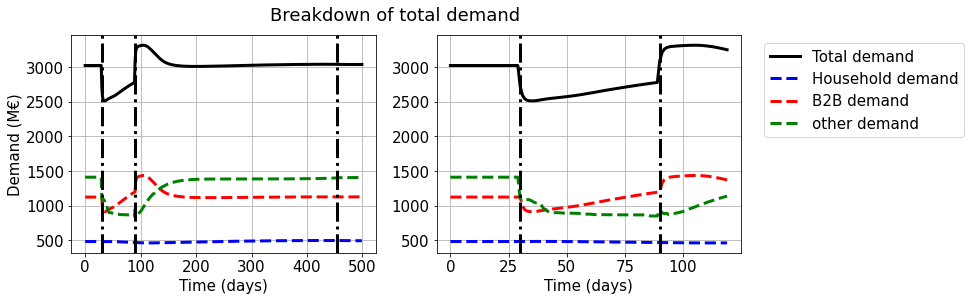

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0),color='black')
ax1.plot(np.arange(0,simtime),np.sum(c_t_array,axis=0),color='blue',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(O_t_array,axis=0),color='red',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(f_t_array,axis=0),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')

ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(d_t_array,axis=0)[0:t_end_lockdown+30],color='black')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(c_t_array,axis=0)[0:t_end_lockdown+30],color='blue',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(O_t_array,axis=0)[0:t_end_lockdown+30],color='red',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(f_t_array,axis=0)[0:t_end_lockdown+30],color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.set_xlabel('Time (days)')
lgd=ax2.legend(['Total demand','Household demand','B2B demand','other demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid('on')
fig.savefig('demand_breakdown.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

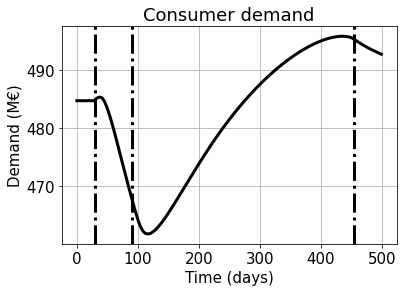

In [277]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),np.sum(c_t_array,axis=0),color='black')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Demand (M€)')
ax.grid('on')
fig.savefig('consumer_government.jpg',dpi=400)

Text(0, 0.5, 'Output (M€)')

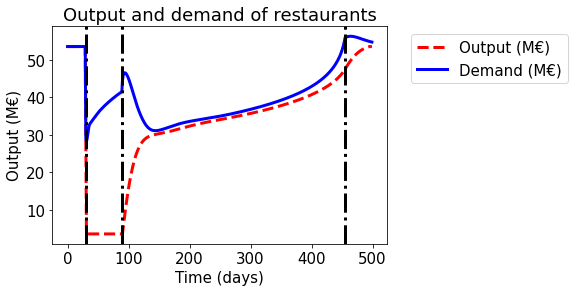

In [278]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),x_t_array[-28,:],color='red',ls='--')
ax.plot(np.arange(0,simtime),d_t_array[-28,:],color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Output and demand of restaurants')
ax.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')

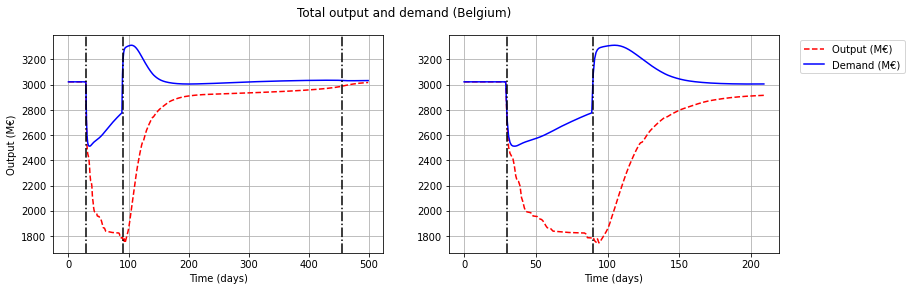

In [14]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(13,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(np.arange(0,simtime),np.sum(x_t_array,axis=0),color='red',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Output (M€)')
ax1.grid('on')

ax2.plot(np.arange(0,t_end_lockdown+120),np.sum(x_t_array,axis=0)[0:t_end_lockdown+120],color='red',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+120),np.sum(d_t_array,axis=0)[0:t_end_lockdown+120],color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlabel('Time (days)')
ax2.grid('on')

fig.savefig('total_output_demand.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

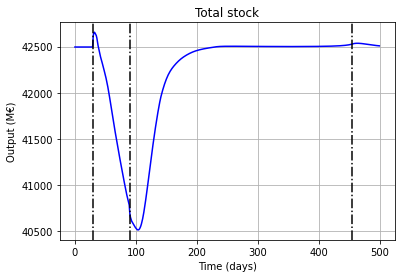

In [15]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),np.sum(S_t_array,axis=0),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')
ax.grid('on')
plt.savefig('total_stock.jpg',dpi=400)

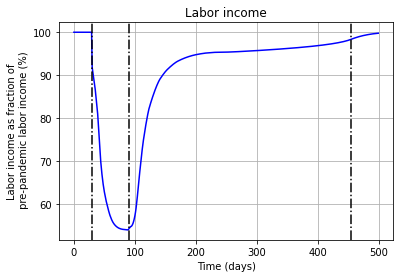

In [16]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),(np.sum(l_t_array,axis=0)/np.sum(pars['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid('on')
fig.savefig('active_workers.jpg',dpi=400)

In [17]:
x_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(x_t_array[:,0],axis=1))))
d_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(d_t_array[:,0],axis=1))))
l_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(l_t_array[:,0],axis=1))))

for i in range(1,x_t_array[0,:].shape[0]):
    print(i)
    x_t_10 = np.append(x_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(x_t_array[:,i],axis=1)))),axis=1)
    d_t_10 = np.append(d_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(d_t_array[:,i],axis=1)))),axis=1)
    l_t_10 = np.append(l_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(l_t_array[:,i],axis=1)))),axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [18]:
labels=pd.read_excel("../../data/interim/economical/conversion_matrices.xlsx", sheet_name = 'NACE 21 to NACE 10', header=[0], index_col=[0]).index.values

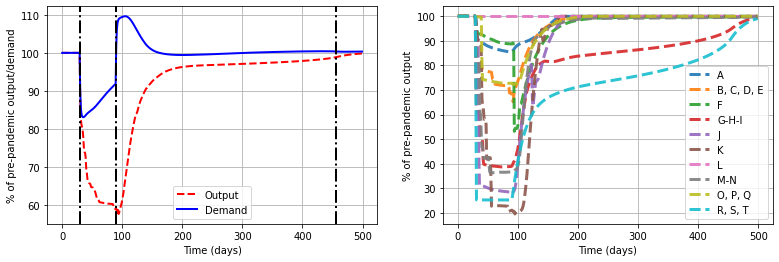

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

ax1.plot(np.arange(0,simtime),np.sum(x_t_array,axis=0)/np.sum(x_t_array,axis=0)[0]*100,color='red',ls='--',linewidth=2)
ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0)/np.sum(d_t_array,axis=0)[0]*100,color='blue',linewidth=2)
ax1.axvline(t_start_lockdown,color='black',linestyle='-.',linewidth=2)
ax1.axvline(t_end_lockdown,color='black',linestyle='-.',linewidth=2)
ax1.axvline(t_end_pandemic,color='black',linestyle='-.',linewidth=2)
ax1.legend(['Output','Demand'])
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('% of pre-pandemic output/demand')
ax1.grid('on')

for i in range(x_t_10.shape[0]):
    ax2.plot(np.arange(0,simtime),(x_t_10[i,:]/x_t_10[i,0]*100),ls='--',linewidth=3, alpha=0.9)
    
ax2.grid('on')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('% of pre-pandemic output')
ax2.legend(labels)
fig.savefig('output_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

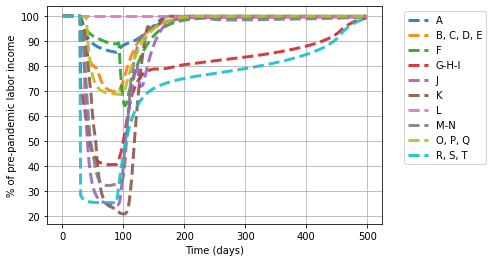

In [20]:
fig,ax=plt.subplots()

for i in range(x_t_10.shape[0]):
    ax.plot(np.arange(0,simtime),l_t_10[i,:]/l_t_10[i,0]*100,ls='--',linewidth=3, alpha=0.9)
    
ax.grid('on')
ax.set_xlabel('Time (days)')
ax.set_ylabel('% of pre-pandemic labor income')
ax.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

In [21]:
import datetime
df = pd.read_excel("../../data/interim/economical/ERMG_revenue_survey.xlsx",index_col=[0], header=[0])
datetime_dates=[datetime.datetime.strptime(date,"%Y-%m-%d") for date in df.columns]

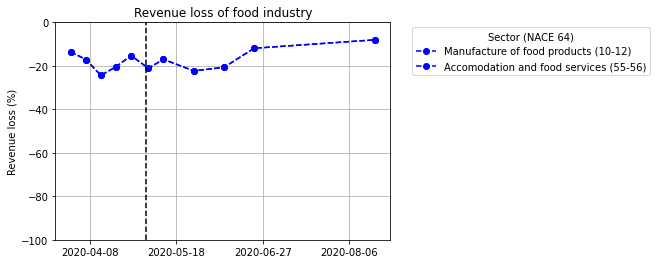

In [22]:
# Manufacture of food products

fig,ax = plt.subplots()

ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')
ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')

ax.set_ylim([-100,0])
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.axvline(datetime.datetime.strptime('2020-05-04',"%Y-%m-%d"),color='black',ls='--')
ax.set_ylabel('Revenue loss (%)')
ax.set_title('Revenue loss of food industry')
lgd=ax.legend(['Manufacture of food products (10-12)', 'Accomodation and food services (55-56)'], title='Sector (NACE 64)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')
fig.savefig('food_sector.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

### Attempt to incorporate in modeling framework of BIOMATH

In [5]:
from covid19model.models import models
from covid19model.data.economic_parameters import get_economic_parameters
from covid19model.models.economic_utils import *

In [7]:
# Load the parameters using `get_economic_parameters()`.
params = get_economic_parameters()

# Parameters
# ----------
start_date = '2020-03-01'
end_date = '2020-12-31'
t_start_lockdown = pd.Timestamp('2020-03-15')
t_end_lockdown =pd.Timestamp('2020-05-04')
t_end_pandemic = pd.Timestamp('2020-08-01')
                    
params.update({'rho': 1-(1-0.6)/90, # Economic recovery time (0.6 quarters?)
               'delta_S': 0.5, # household savings rate (delta_S = 1; households save all money they are not spending due to shock)
               'L': 0.5, # Fraction of population believing in L-shaped recovery
               'l_start_lockdown': sum((1-params['l_s'])*params['l_0']), # Verify this must be the sum
               'zeta': 1,
               'tau': 10, # Restock rate (days)
               'gamma_F': 1/7, # Firing rate (days-1)
               'gamma_H': 1/28 }) # Hiring rate (days-1)


# Time-dependent parameters
# -------------------------
params.update({'epsilon_S': np.zeros([params['c_s'].shape[0]]),
                'epsilon_D': np.zeros([params['c_s'].shape[0]]),
                'epsilon_F': np.zeros([params['c_s'].shape[0]]),
                't_start_lockdown': t_start_lockdown,
                't_end_lockdown': t_end_lockdown,
                't_end_pandemic': t_end_pandemic,
                'b': 0,
                'b_s': 0,
                't_start_compensation': pd.Timestamp('2020-04-01'),
                't_end_compensation': pd.Timestamp('2020-07-01')})

# Load initial states
initial_states = {'x': params['x_0'],
                  'c': params['c_0'],
                  'c_desired': params['c_0'],
                  'f': params['f_0'],
                  'd': params['x_0'],
                  'l': params['l_0'],
                  'O': params['O_j'],
                  'S': params['S_0']}

# Initialize the model
model = models.Economic_Model(initial_states, params, discrete=True, time_dependent_parameters={'epsilon_S': labor_supply_shock,
                                                                                                'epsilon_D': household_demand_shock,
                                                                                                'epsilon_F': other_demand_shock,
                                                                                                'b': government_furloughing,
                                                                                                'zeta': compute_income_expectations})

In [10]:
out=model.sim(end_date, start_date=start_date, warmup=0)

{'x': array([[4.59787853e+01, 1.77479693e+00, 1.17561644e+00, 6.64423422e+01,
        1.54483328e+02, 3.50728404e+01, 1.33959746e+01, 2.15265188e+01,
        8.74793544e+00, 8.92420816e+01, 1.72148509e+02, 5.85698498e+01,
        3.85954415e+01, 2.42842299e+01, 8.13177814e+01, 3.95730721e+01,
        4.13389046e+01, 2.77957465e+01, 6.38509171e+01, 1.16404959e+02,
        1.22588767e+01, 4.71042695e+01, 2.32010885e+01, 5.22839766e+01,
        3.37752948e+00, 4.04049431e+01, 1.87198639e+02, 3.19076759e+01,
        1.54447818e+02, 6.46880195e+01, 7.41191957e+01, 1.41670959e+01,
        2.16197232e+01, 8.62047869e+01, 1.20687179e+01, 5.34982357e+01,
        1.64998617e+01, 1.41571121e+01, 3.83630212e+01, 5.84484662e+01,
        5.69803743e+01, 2.58849260e+01, 5.60656384e+01, 1.27062318e+02,
        5.54330276e+01, 3.63102376e+01, 5.49433699e+01, 2.70882119e+01,
        7.61279620e+00, 4.84688153e+01, 2.09900509e+01, 8.83685949e+00,
        3.83534054e+01, 9.26224619e+01, 7.44334895e+01, 8.

/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])
/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])


{'x': array([[4.59787853e+01, 1.77479693e+00, 1.17561644e+00, 6.64423422e+01,
        1.54483328e+02, 3.50728404e+01, 1.33959746e+01, 2.15265188e+01,
        8.74793544e+00, 8.92420816e+01, 1.72148509e+02, 5.85698498e+01,
        3.85954415e+01, 2.42842299e+01, 8.13177814e+01, 3.95730721e+01,
        4.13389046e+01, 2.77957465e+01, 6.38509171e+01, 1.16404959e+02,
        1.22588767e+01, 4.71042695e+01, 2.32010885e+01, 5.22839766e+01,
        3.37752948e+00, 4.04049431e+01, 1.87198639e+02, 3.19076759e+01,
        1.54447818e+02, 6.46880195e+01, 7.41191957e+01, 1.41670959e+01,
        2.16197232e+01, 8.62047869e+01, 1.20687179e+01, 5.34982357e+01,
        1.64998617e+01, 1.41571121e+01, 3.83630212e+01, 5.84484662e+01,
        5.69803743e+01, 2.58849260e+01, 5.60656384e+01, 1.27062318e+02,
        5.54330276e+01, 3.63102376e+01, 5.49433699e+01, 2.70882119e+01,
        7.61279620e+00, 4.84688153e+01, 2.09900509e+01, 8.83685949e+00,
        3.83534054e+01, 9.26224619e+01, 7.44334895e+01, 8.

{'x': array([[4.09467697e+01, 1.56928086e+00, 1.02711988e+00, 4.80836457e+01,
        1.31819194e+02, 3.23445998e+01, 1.17713542e+01, 1.64951393e+01,
        6.40502162e+00, 6.78717072e+01, 1.23882930e+02, 4.61762983e+01,
        2.99005956e+01, 2.02449770e+01, 5.68808362e+01, 3.27084064e+01,
        3.11401437e+01, 2.21669453e+01, 4.58703927e+01, 8.91155625e+01,
        9.40588059e+00, 4.00382110e+01, 1.81193712e+01, 4.84748416e+01,
        3.37752948e+00, 3.48195500e+01, 1.72706874e+02, 1.27740242e+01,
        1.23825977e+02, 1.79705322e+01, 8.85248587e+00, 9.67490407e+00,
        1.43890802e+01, 2.30444982e+01, 1.85968112e+00, 3.58270468e+00,
        1.37965859e+01, 1.21111448e+01, 5.68194263e+00, 7.92219863e+00,
        2.08187277e+01, 2.06228885e+01, 4.67537664e+01, 1.27062318e+02,
        1.71975876e+01, 5.52478850e+00, 4.85558011e+01, 1.93258162e+01,
        6.59640045e+00, 1.50597770e+01, 6.30958387e+00, 3.44082832e+00,
        1.22107314e+01, 1.70127607e+01, 7.34575433e+01, 8.

{'x': array([[4.02915787e+01, 1.53696775e+00, 9.90601780e-01, 4.76547572e+01,
        1.29381025e+02, 3.21308890e+01, 1.15373942e+01, 1.57172011e+01,
        5.68619125e+00, 6.63600414e+01, 1.23280432e+02, 4.59474121e+01,
        2.94448523e+01, 1.97323539e+01, 5.68126048e+01, 3.21647342e+01,
        3.04656036e+01, 2.19147950e+01, 4.55914749e+01, 8.89484949e+01,
        9.21590826e+00, 3.98737828e+01, 1.68266546e+01, 4.72448142e+01,
        3.37752948e+00, 3.35489625e+01, 1.70024814e+02, 1.27740242e+01,
        1.21165750e+02, 1.78822369e+01, 1.02905357e+01, 9.59280106e+00,
        1.19452408e+01, 1.22331456e+01, 1.93647071e+00, 3.58270468e+00,
        1.30714135e+01, 1.17329442e+01, 5.48574246e+00, 7.83867911e+00,
        2.19548255e+01, 1.30286449e+01, 2.41140190e+01, 1.27062318e+02,
        7.72733917e+00, 6.16830772e+00, 4.85625837e+01, 1.84265828e+01,
        6.09800849e+00, 8.70467390e+00, 3.98761904e+00, 3.32313686e+00,
        6.87104247e+00, 1.53060963e+01, 7.31514935e+01, 8.

{'x': array([[3.98867437e+01, 1.51147688e+00, 9.72037875e-01, 4.73325776e+01,
        1.28004932e+02, 3.19371165e+01, 1.13167083e+01, 1.53506570e+01,
        5.35606223e+00, 6.54807129e+01, 1.22713287e+02, 4.58307859e+01,
        2.91987303e+01, 1.94608081e+01, 5.67259568e+01, 3.18679213e+01,
        3.01532882e+01, 2.17628882e+01, 4.54370953e+01, 8.87474046e+01,
        9.11926686e+00, 3.97380187e+01, 1.59863399e+01, 1.59011380e+01,
        1.04046674e+00, 1.10716343e+01, 1.68023252e+02, 1.27740242e+01,
        1.19674060e+02, 1.77490164e+01, 1.13718326e+01, 9.54129637e+00,
        1.06465079e+01, 1.25757570e+01, 1.94949564e+00, 3.58270468e+00,
        1.26451101e+01, 1.15304015e+01, 5.35447889e+00, 7.75140194e+00,
        1.19023796e+01, 7.07825161e+00, 1.30305379e+01, 1.27062318e+02,
        7.28271459e+00, 6.57734442e+00, 4.85626476e+01, 1.78167481e+01,
        5.83460557e+00, 9.32391629e+00, 4.57850530e+00, 1.71773449e+00,
        7.11433176e+00, 1.42232556e+01, 7.29466671e+01, 8.

{'x': array([[3.95905664e+01, 1.49470835e+00, 9.60210589e-01, 4.71127699e+01,
        1.27035064e+02, 3.17602541e+01, 1.11690475e+01, 1.51737983e+01,
        5.21303025e+00, 6.49482988e+01, 1.22293156e+02, 4.57528783e+01,
        2.90491929e+01, 1.93080574e+01, 5.66478300e+01, 3.16889248e+01,
        2.99962821e+01, 2.16535239e+01, 4.53404526e+01, 8.85633222e+01,
        9.05846377e+00, 3.96178361e+01, 1.54373906e+01, 1.59124725e+01,
        9.83275365e-01, 1.09796458e+01, 1.66700008e+02, 1.27740242e+01,
        1.18724040e+02, 1.76028716e+01, 1.18234162e+01, 9.50549163e+00,
        1.01110857e+01, 1.24734423e+01, 1.90274280e+00, 3.58270468e+00,
        1.24262583e+01, 1.14199604e+01, 5.23385845e+00, 7.66669826e+00,
        1.19876831e+01, 7.03221123e+00, 1.28270363e+01, 1.27062318e+02,
        6.94610365e+00, 6.75115225e+00, 4.85605543e+01, 1.75240156e+01,
        5.69805766e+00, 9.75275500e+00, 4.84057946e+00, 1.66034136e+00,
        7.24703619e+00, 1.30489569e+01, 7.28266874e+01, 8.

{'x': array([[4.09545567e+01, 1.54883870e+00, 9.82524620e-01, 5.10331553e+01,
        1.33100763e+02, 3.30370479e+01, 1.15361442e+01, 1.61868144e+01,
        5.46144738e+00, 3.59168050e+01, 1.33103753e+02, 4.89195843e+01,
        3.09409975e+01, 2.01848728e+01, 6.19320616e+01, 3.30941608e+01,
        3.22553284e+01, 2.30624017e+01, 4.93390905e+01, 9.51862439e+01,
        9.74899773e+00, 4.16804278e+01, 1.62079627e+01, 1.61142620e+01,
        9.94476959e-01, 1.15905947e+01, 1.69414180e+02, 1.49460312e+01,
        1.25715845e+02, 1.78942477e+01, 1.86969088e+01, 1.03800523e+01,
        1.10419841e+01, 1.30944754e+01, 1.94113658e+00, 1.26128636e+01,
        1.29465313e+01, 1.17797933e+01, 7.34533414e+00, 1.09274595e+01,
        1.08677245e+01, 6.02017022e+00, 1.17002876e+01, 1.27062318e+02,
        7.24952711e+00, 6.94333211e+00, 4.99745376e+01, 1.88860817e+01,
        5.89265583e+00, 9.81495898e+00, 5.30567383e+00, 1.59795265e+00,
        7.20627944e+00, 1.27569290e+01, 7.31857233e+01, 8.

{'x': array([[4.24632537e+01, 1.60891381e+00, 1.00527199e+00, 5.47731053e+01,
        1.39576241e+02, 3.43233503e+01, 1.19197669e+01, 1.73592037e+01,
        5.72449758e+00, 6.06287838e+01, 1.45395085e+02, 5.25380129e+01,
        3.31128395e+01, 2.12164061e+01, 6.81807471e+01, 3.46650566e+01,
        3.46787252e+01, 2.46020961e+01, 5.37106987e+01, 1.02266228e+02,
        1.04854053e+01, 4.38368413e+01, 1.69820020e+01, 2.85992604e+01,
        1.78191106e+00, 2.21927175e+01, 1.61047954e+02, 1.72472816e+01,
        1.33559135e+02, 1.85313134e+01, 5.51516174e+01, 1.14011277e+01,
        1.19561928e+01, 3.46467695e+01, 4.82910302e+00, 2.17073314e+01,
        1.34570918e+01, 1.21597010e+01, 2.01907718e+01, 3.04546186e+01,
        1.30610385e+01, 6.33583617e+00, 1.21909397e+01, 1.27062318e+02,
        1.68862003e+01, 1.69620315e+01, 5.14644991e+01, 2.04894331e+01,
        6.08794177e+00, 2.43343710e+01, 1.30759978e+01, 3.40978165e+00,
        1.71542008e+01, 2.73914279e+01, 7.35082580e+01, 8.

{'x': array([[4.37452892e+01, 1.65738823e+00, 1.03392112e+00, 5.72253077e+01,
        1.45355933e+02, 3.50728404e+01, 1.22041810e+01, 1.84410352e+01,
        6.05445321e+00, 7.32726233e+01, 1.55824982e+02, 5.56412065e+01,
        3.49534288e+01, 2.19947620e+01, 7.34201856e+01, 3.59460305e+01,
        3.68476332e+01, 2.58830948e+01, 5.74456656e+01, 1.08275484e+02,
        1.11269989e+01, 4.56462212e+01, 1.78765363e+01, 4.42781827e+01,
        2.83859135e+00, 3.66377979e+01, 1.68172673e+02, 1.92975714e+01,
        1.40391306e+02, 1.97892532e+01, 7.41191957e+01, 1.22930898e+01,
        1.31540495e+01, 6.97628523e+01, 9.72332789e+00, 2.77709721e+01,
        1.39658517e+01, 1.25227166e+01, 3.04262559e+01, 4.54621553e+01,
        3.81245751e+01, 1.34942774e+01, 2.61171053e+01, 1.27062318e+02,
        3.15245717e+01, 3.26855728e+01, 5.27325328e+01, 2.20049408e+01,
        6.31086056e+00, 4.80738740e+01, 2.09900509e+01, 6.56960945e+00,
        3.35499300e+01, 5.34653225e+01, 7.37985382e+01, 8.

{'x': array([[4.46772188e+01, 1.69447762e+00, 1.06365642e+00, 5.89999017e+01,
        1.49237679e+02, 3.50728404e+01, 1.24501885e+01, 1.92375724e+01,
        6.48266746e+00, 8.05707294e+01, 1.61871020e+02, 5.72948498e+01,
        3.60856274e+01, 2.25246285e+01, 7.63617900e+01, 3.68301575e+01,
        3.82551650e+01, 2.66451549e+01, 5.96485061e+01, 1.11778315e+02,
        1.15295411e+01, 4.66682484e+01, 1.89624144e+01, 5.14890069e+01,
        3.35624582e+00, 4.04049431e+01, 1.73247738e+02, 2.07956536e+01,
        1.44895271e+02, 2.13870189e+01, 7.41191957e+01, 1.28324872e+01,
        1.46908513e+01, 8.50044771e+01, 1.18843707e+01, 3.02747307e+01,
        1.44801780e+01, 1.28547842e+01, 2.88164920e+01, 4.16933099e+01,
        5.34143169e+01, 2.24223984e+01, 4.37429950e+01, 1.27062318e+02,
        4.00818405e+01, 3.63102376e+01, 5.34881768e+01, 2.31691803e+01,
        6.59363993e+00, 4.84688153e+01, 2.09900509e+01, 8.21965287e+00,
        3.83534054e+01, 6.84024310e+01, 7.40291159e+01, 8.

{'x': array([[4.54383049e+01, 1.72647292e+00, 1.09229069e+00, 6.08872613e+01,
        1.52069832e+02, 3.50728404e+01, 1.27042559e+01, 1.98910842e+01,
        6.97798555e+00, 8.48634834e+01, 1.65731999e+02, 5.81992534e+01,
        3.68703428e+01, 2.29750272e+01, 7.81697905e+01, 3.75489360e+01,
        3.92514334e+01, 2.71482248e+01, 6.10894715e+01, 1.14020489e+02,
        1.18103667e+01, 4.71042695e+01, 2.01701084e+01, 5.22839766e+01,
        3.37752948e+00, 4.04049431e+01, 1.77173800e+02, 2.21080629e+01,
        1.48203334e+02, 2.34559931e+01, 7.41191957e+01, 1.31925047e+01,
        1.64819003e+01, 8.62047869e+01, 1.20687179e+01, 3.18548539e+01,
        1.50026204e+01, 1.31626805e+01, 3.34774457e+01, 4.89837770e+01,
        4.93657120e+01, 2.58849260e+01, 5.36060181e+01, 1.27062318e+02,
        4.56051802e+01, 3.63102376e+01, 5.39928377e+01, 2.41704136e+01,
        6.91577358e+00, 4.84688153e+01, 2.09900509e+01, 8.83685949e+00,
        3.83534054e+01, 7.77641473e+01, 7.42276665e+01, 8.

{'x': array([[4.59787853e+01, 1.75102115e+00, 1.11536511e+00, 6.27751606e+01,
        1.53954728e+02, 3.50728404e+01, 1.29340696e+01, 2.03984600e+01,
        7.44401653e+00, 8.72326825e+01, 1.68178305e+02, 5.85698498e+01,
        3.74120231e+01, 2.33512880e+01, 7.92835069e+01, 3.81220153e+01,
        3.99638816e+01, 2.74755873e+01, 6.20341392e+01, 1.15420687e+02,
        1.20028987e+01, 4.71042695e+01, 2.12695196e+01, 5.22839766e+01,
        3.37752948e+00, 4.04049431e+01, 1.80105465e+02, 2.33404320e+01,
        1.50548775e+02, 2.61451322e+01, 6.94781345e+01, 1.34357655e+01,
        1.81688569e+01, 8.48260663e+01, 1.15563364e+01, 3.35631898e+01,
        1.54689051e+01, 1.34262848e+01, 3.66894090e+01, 5.37513845e+01,
        5.20291896e+01, 2.58849260e+01, 5.60656384e+01, 1.27062318e+02,
        4.91650542e+01, 3.63102376e+01, 5.43304139e+01, 2.49838753e+01,
        7.21103105e+00, 4.84688153e+01, 2.09900509e+01, 8.83685949e+00,
        3.83534054e+01, 8.36020818e+01, 7.43848208e+01, 8.

{'x': array([[4.59787853e+01, 1.76456207e+00, 1.12842673e+00, 6.41398183e+01,
        1.54483328e+02, 3.50728404e+01, 1.30842660e+01, 2.07088633e+01,
        7.76138192e+00, 8.82885206e+01, 1.69492094e+02, 5.85698498e+01,
        3.77249099e+01, 2.35996519e+01, 7.98829311e+01, 3.84923623e+01,
        4.03912080e+01, 2.76465279e+01, 6.25660868e+01, 1.16124778e+02,
        1.21095302e+01, 4.71042695e+01, 2.19756609e+01, 5.22839766e+01,
        3.37752948e+00, 4.04049431e+01, 1.81896861e+02, 2.43864249e+01,
        1.51860144e+02, 2.91333599e+01, 6.91665116e+01, 1.35812746e+01,
        1.92765340e+01, 8.36682613e+01, 1.14581171e+01, 3.54392214e+01,
        1.57750552e+01, 1.35986599e+01, 3.81230090e+01, 5.59049379e+01,
        5.52660389e+01, 2.58849260e+01, 5.60656384e+01, 1.27062318e+02,
        5.11368200e+01, 3.60333169e+01, 5.45222718e+01, 2.55072391e+01,
        7.39720554e+00, 4.84688153e+01, 2.09900509e+01, 8.83685949e+00,
        3.80334118e+01, 8.67248776e+01, 7.44334895e+01, 8.

{'x': array([[4.56190931e+01, 1.75446211e+00, 1.12502600e+00, 6.53316422e+01,
        1.52325261e+02, 3.50728404e+01, 1.31973689e+01, 2.09479001e+01,
        8.04647652e+00, 8.88047844e+01, 1.70431214e+02, 5.85081413e+01,
        3.79622148e+01, 2.38039120e+01, 8.03521355e+01, 3.88126877e+01,
        4.07266864e+01, 2.76563414e+01, 6.29911915e+01, 1.16355418e+02,
        1.21762075e+01, 4.70927753e+01, 2.25188115e+01, 5.18510284e+01,
        3.37752948e+00, 4.04049431e+01, 1.83397184e+02, 2.59519553e+01,
        1.52642306e+02, 3.49012709e+01, 6.96395560e+01, 1.37173131e+01,
        2.02079457e+01, 8.38608634e+01, 1.14953308e+01, 3.89558233e+01,
        1.60030888e+01, 1.37265761e+01, 3.83630212e+01, 4.68960223e+01,
        5.56922810e+01, 2.58849260e+01, 5.56432953e+01, 1.25385607e+02,
        5.26977416e+01, 3.57292736e+01, 5.46750674e+01, 2.59710870e+01,
        7.51756530e+00, 3.96646373e+01, 2.09900509e+01, 7.63715533e+00,
        3.10919205e+01, 8.90537254e+01, 7.43364458e+01, 8.

{'x': array([[4.48632122e+01, 1.73973790e+00, 1.10904509e+00, 6.58772305e+01,
        1.50600102e+02, 3.46108142e+01, 1.32180363e+01, 2.10264632e+01,
        8.23894028e+00, 8.81235839e+01, 1.70737651e+02, 5.83015736e+01,
        3.80385963e+01, 2.38731524e+01, 8.06112621e+01, 3.89802565e+01,
        4.08451703e+01, 2.75275158e+01, 6.32237169e+01, 1.15870994e+02,
        1.21523688e+01, 4.67796844e+01, 2.27236028e+01, 5.08912587e+01,
        3.28631342e+00, 3.98456187e+01, 1.84201886e+02, 2.80610449e+01,
        1.51732926e+02, 4.40200398e+01, 7.06445254e+01, 1.38264014e+01,
        2.07298793e+01, 8.40207949e+01, 1.14925603e+01, 4.43134458e+01,
        1.59472686e+01, 1.36745580e+01, 3.74279093e+01, 4.94823457e+01,
        5.56155935e+01, 2.53262966e+01, 5.45107395e+01, 1.21611115e+02,
        5.35874176e+01, 3.55815085e+01, 5.47600081e+01, 2.62434929e+01,
        7.39133569e+00, 4.14865052e+01, 2.09900509e+01, 7.41493813e+00,
        3.22286368e+01, 9.01727860e+01, 7.41997201e+01, 8.

{'x': array([[4.49332641e+01, 1.74263789e+00, 1.11177753e+00, 6.61245891e+01,
        1.50857021e+02, 3.46181462e+01, 1.32232573e+01, 2.10539119e+01,
        8.32185965e+00, 8.81886597e+01, 1.70939676e+02, 5.83258704e+01,
        3.80815624e+01, 2.39095876e+01, 8.07920857e+01, 3.90924561e+01,
        4.09206982e+01, 2.75477261e+01, 6.33806347e+01, 1.15893773e+02,
        1.21568354e+01, 4.67909428e+01, 2.26891122e+01, 5.09479577e+01,
        3.27659438e+00, 3.98572615e+01, 1.84750783e+02, 2.94952010e+01,
        1.51866007e+02, 5.02686894e+01, 7.14875935e+01, 1.38980595e+01,
        2.09018090e+01, 8.41252873e+01, 1.15261807e+01, 4.80181981e+01,
        1.59556850e+01, 1.36905739e+01, 3.74090770e+01, 5.34933577e+01,
        5.60585806e+01, 2.51638037e+01, 5.46271315e+01, 1.21837025e+02,
        5.41822055e+01, 3.56246544e+01, 5.48186026e+01, 2.63764029e+01,
        7.38517430e+00, 4.52427907e+01, 2.09900509e+01, 7.81256687e+00,
        3.56916483e+01, 9.08989383e+01, 7.42170405e+01, 8.

{'x': array([[4.49678006e+01, 1.74487357e+00, 1.11522912e+00, 6.62094349e+01,
        1.50996711e+02, 3.46299684e+01, 1.32360251e+01, 2.10981034e+01,
        8.37666516e+00, 8.82339240e+01, 1.71143789e+02, 5.83368300e+01,
        3.81440290e+01, 2.39574340e+01, 8.09430844e+01, 3.91969567e+01,
        4.09945649e+01, 2.75613126e+01, 6.35110627e+01, 1.15907496e+02,
        1.21634569e+01, 4.67980140e+01, 2.27020838e+01, 5.10007947e+01,
        3.28069771e+00, 3.98835253e+01, 1.85272297e+02, 3.04902934e+01,
        1.52022580e+02, 5.50511913e+01, 7.22462847e+01, 1.39621460e+01,
        2.09614996e+01, 8.43609302e+01, 1.16253129e+01, 5.05155416e+01,
        1.59839991e+01, 1.37233433e+01, 3.74543606e+01, 5.66089316e+01,
        5.62724842e+01, 2.51978714e+01, 5.46964885e+01, 1.22014148e+02,
        5.46376667e+01, 3.56858018e+01, 5.48636623e+01, 2.64910512e+01,
        7.39760460e+00, 4.79630679e+01, 2.09900509e+01, 8.16943841e+00,
        3.81508056e+01, 9.14522135e+01, 7.42248782e+01, 8.

{'x': array([[4.50387932e+01, 1.74818921e+00, 1.12182492e+00, 6.61398790e+01,
        1.51273493e+02, 3.46399969e+01, 1.32532351e+01, 2.11521465e+01,
        8.42703646e+00, 8.83192481e+01, 1.71288628e+02, 5.83479380e+01,
        3.82058926e+01, 2.40058472e+01, 8.10317062e+01, 3.92690813e+01,
        4.10494526e+01, 2.75803056e+01, 6.35897425e+01, 1.15926853e+02,
        1.21712753e+01, 4.68053023e+01, 2.27335108e+01, 5.10921456e+01,
        3.28338935e+00, 3.99217852e+01, 1.85632480e+02, 3.09533806e+01,
        1.52273407e+02, 5.76624198e+01, 7.27044618e+01, 1.40065810e+01,
        2.10106823e+01, 8.46434062e+01, 1.17355978e+01, 5.15670063e+01,
        1.60427952e+01, 1.37765222e+01, 3.75034199e+01, 5.78907097e+01,
        5.60184831e+01, 2.52174161e+01, 5.48440731e+01, 1.22303023e+02,
        5.48861691e+01, 3.57797032e+01, 5.48877007e+01, 2.65907382e+01,
        7.41776332e+00, 4.84688153e+01, 2.09900509e+01, 8.34814323e+00,
        3.83534054e+01, 9.17562389e+01, 7.42386352e+01, 8.

{'x': array([[4.51264360e+01, 1.75174265e+00, 1.12976296e+00, 6.61280152e+01,
        1.51604508e+02, 3.46540829e+01, 1.32724316e+01, 2.12104441e+01,
        8.48615748e+00, 8.84194697e+01, 1.71406397e+02, 5.83578036e+01,
        3.82663330e+01, 2.40547495e+01, 8.10945908e+01, 3.93269299e+01,
        4.10963866e+01, 2.76004632e+01, 6.36472201e+01, 1.15951388e+02,
        1.21789945e+01, 4.68149536e+01, 2.27980725e+01, 5.12106327e+01,
        3.28826782e+00, 3.99735621e+01, 1.85921768e+02, 3.12145840e+01,
        1.52557146e+02, 5.94177523e+01, 7.30209864e+01, 1.40429355e+01,
        2.10841510e+01, 8.49411185e+01, 1.18400181e+01, 5.20690648e+01,
        1.61158761e+01, 1.38369155e+01, 3.75733251e+01, 5.83940666e+01,
        5.60431750e+01, 2.52598668e+01, 5.50193600e+01, 1.22673954e+02,
        5.50528605e+01, 3.58843810e+01, 5.49033859e+01, 2.66902819e+01,
        7.44697036e+00, 4.84688153e+01, 2.09900509e+01, 8.45696949e+00,
        3.83534054e+01, 9.19627285e+01, 7.42546885e+01, 8.

{'x': array([[4.52125291e+01, 1.75491765e+00, 1.13727691e+00, 6.61346452e+01,
        1.51921857e+02, 3.46693395e+01, 1.32905218e+01, 2.12639821e+01,
        8.54639408e+00, 8.85152774e+01, 1.71500784e+02, 5.83660680e+01,
        3.83190956e+01, 2.40981472e+01, 8.11396190e+01, 3.93717176e+01,
        4.11345965e+01, 2.76189403e+01, 6.36891043e+01, 1.15976202e+02,
        1.21857918e+01, 4.68251748e+01, 2.28779404e+01, 5.13295356e+01,
        3.29394704e+00, 4.00262286e+01, 1.86148277e+02, 3.13607354e+01,
        1.52821205e+02, 6.06009000e+01, 7.32308095e+01, 1.40713771e+01,
        2.11719071e+01, 8.52095830e+01, 1.19197897e+01, 5.22889752e+01,
        1.61866009e+01, 1.38926212e+01, 3.76467786e+01, 5.84484662e+01,
        5.60608752e+01, 2.53124416e+01, 5.51813131e+01, 1.23048020e+02,
        5.51647514e+01, 3.59797095e+01, 5.49136445e+01, 2.67791639e+01,
        7.47742231e+00, 4.82063265e+01, 2.09900509e+01, 8.52310483e+00,
        3.81496555e+01, 9.21036456e+01, 7.42703709e+01, 8.

{'x': array([[4.52870089e+01, 1.75743821e+00, 1.14337807e+00, 6.61435879e+01,
        1.52189867e+02, 3.46840220e+01, 1.33057487e+01, 2.13080437e+01,
        8.59847736e+00, 8.85968642e+01, 1.71576376e+02, 5.83730617e+01,
        3.83615835e+01, 2.41325786e+01, 8.11724494e+01, 3.94053478e+01,
        4.11641673e+01, 2.76346596e+01, 6.37196313e+01, 1.15998485e+02,
        1.21915198e+01, 4.68349470e+01, 2.29530144e+01, 5.14328160e+01,
        3.29935252e+00, 4.00717645e+01, 1.86322657e+02, 3.14422570e+01,
        1.53039201e+02, 6.14014387e+01, 7.33671908e+01, 1.40925900e+01,
        2.12572492e+01, 8.54268288e+01, 1.19686179e+01, 5.23803975e+01,
        1.62446726e+01, 1.39376770e+01, 3.77121752e+01, 5.82753280e+01,
        5.61146005e+01, 2.53634117e+01, 5.53090400e+01, 1.23379541e+02,
        5.52399325e+01, 3.60551994e+01, 5.49203954e+01, 2.68494362e+01,
        7.50308724e+00, 4.80474330e+01, 2.09900509e+01, 8.56371951e+00,
        3.79636384e+01, 9.22001848e+01, 7.42841400e+01, 8.

{'x': array([[4.53513181e+01, 1.75942808e+00, 1.14813436e+00, 6.61635322e+01,
        1.52415168e+02, 3.46984909e+01, 1.33185131e+01, 2.13443506e+01,
        8.63959260e+00, 8.86670109e+01, 1.71642156e+02, 5.83796864e+01,
        3.83964759e+01, 2.41592880e+01, 8.11987775e+01, 3.94320316e+01,
        4.11878299e+01, 2.76486032e+01, 6.37437227e+01, 1.16018878e+02,
        1.21967116e+01, 4.68445911e+01, 2.30148079e+01, 5.15210324e+01,
        3.30431421e+00, 4.01099180e+01, 1.86466093e+02, 3.14911625e+01,
        1.53218382e+02, 6.19860119e+01, 7.34633031e+01, 1.41089226e+01,
        2.13337471e+01, 8.56015758e+01, 1.19913935e+01, 5.24237693e+01,
        1.62899736e+01, 1.39734765e+01, 3.77688054e+01, 5.82342885e+01,
        5.61984514e+01, 2.54097323e+01, 5.54059345e+01, 1.23673535e+02,
        5.52942033e+01, 3.61127683e+01, 5.49251994e+01, 2.69026845e+01,
        7.52254183e+00, 4.80255362e+01, 2.09900509e+01, 8.59104177e+00,
        3.79366065e+01, 9.22715561e+01, 7.42963842e+01, 8.

{'x': array([[4.53958333e+01, 1.76070312e+00, 1.15097789e+00, 6.61873310e+01,
        1.52566581e+02, 3.47101808e+01, 1.33270409e+01, 2.13684211e+01,
        8.66240840e+00, 8.87160757e+01, 1.71690522e+02, 5.83851142e+01,
        3.84197544e+01, 2.41754614e+01, 8.12168381e+01, 3.94497694e+01,
        4.12034972e+01, 2.76588698e+01, 6.37598615e+01, 1.16034216e+02,
        1.22007032e+01, 4.68524188e+01, 2.30499260e+01, 5.15807432e+01,
        3.30789493e+00, 4.01350618e+01, 1.86564926e+02, 3.15169103e+01,
        1.53336130e+02, 6.23468861e+01, 7.35230515e+01, 1.41191531e+01,
        2.13841785e+01, 8.57127162e+01, 1.19893983e+01, 5.24481405e+01,
        1.63169859e+01, 1.39959455e+01, 3.78078703e+01, 5.82396030e+01,
        5.62784780e+01, 2.54421736e+01, 5.54637473e+01, 1.23883161e+02,
        5.53271158e+01, 3.61468530e+01, 5.49280963e+01, 2.69334135e+01,
        7.53300049e+00, 4.80351304e+01, 2.09900509e+01, 8.60705149e+00,
        3.79470024e+01, 9.23161910e+01, 7.43052973e+01, 8.

{'x': array([[4.54265733e+01, 1.76154289e+00, 1.15263300e+00, 6.62096891e+01,
        1.52668400e+02, 3.47195997e+01, 1.33327091e+01, 2.13843998e+01,
        8.67326990e+00, 8.87506106e+01, 1.71726444e+02, 5.83896233e+01,
        3.84353710e+01, 2.41851669e+01, 8.12295599e+01, 3.94618688e+01,
        4.12141025e+01, 2.76664958e+01, 6.37709772e+01, 1.16045848e+02,
        1.22038063e+01, 4.68587597e+01, 2.30669124e+01, 5.16208994e+01,
        3.31044819e+00, 4.01515423e+01, 1.86634125e+02, 3.15321757e+01,
        1.53413577e+02, 6.25779656e+01, 7.35634103e+01, 1.41256041e+01,
        2.14148359e+01, 8.57824082e+01, 1.19834962e+01, 5.24682385e+01,
        1.63326616e+01, 1.40099758e+01, 3.78348836e+01, 5.82420524e+01,
        5.63416080e+01, 2.54643233e+01, 5.54989525e+01, 1.24032309e+02,
        5.53476952e+01, 3.61668454e+01, 5.49299153e+01, 2.69505761e+01,
        7.53804065e+00, 4.80401691e+01, 2.09900509e+01, 8.61718780e+00,
        3.79522088e+01, 9.23451290e+01, 7.43118321e+01, 8.

{'x': array([[4.54522725e+01, 1.76223109e+00, 1.15377712e+00, 6.62318975e+01,
        1.52751757e+02, 3.47288156e+01, 1.33372542e+01, 2.13971428e+01,
        8.67812989e+00, 8.87800930e+01, 1.71758546e+02, 5.83941662e+01,
        3.84480332e+01, 2.41922323e+01, 8.12404412e+01, 3.94719358e+01,
        4.12228690e+01, 2.76733498e+01, 6.37802910e+01, 1.16056639e+02,
        1.22067103e+01, 4.68649992e+01, 2.30746451e+01, 5.16535872e+01,
        3.31266089e+00, 4.01646720e+01, 1.86692717e+02, 3.15442355e+01,
        1.53475353e+02, 6.27598149e+01, 7.35978959e+01, 1.41304928e+01,
        2.14356143e+01, 8.58342482e+01, 1.19845809e+01, 5.24908254e+01,
        1.63434361e+01, 1.40205099e+01, 3.78576579e+01, 5.82482516e+01,
        5.63943247e+01, 2.54824533e+01, 5.55260242e+01, 1.24161069e+02,
        5.53633627e+01, 3.61809356e+01, 5.49313208e+01, 2.69618336e+01,
        7.54065166e+00, 4.80526563e+01, 2.09900509e+01, 8.62539086e+00,
        3.79657748e+01, 9.23681833e+01, 7.43176505e+01, 8.

{'x': array([[4.54718330e+01, 1.76275742e+00, 1.15449759e+00, 6.62498878e+01,
        1.52814445e+02, 3.47370414e+01, 1.33405627e+01, 2.14061984e+01,
        8.67923906e+00, 8.88028872e+01, 1.71784167e+02, 5.83983073e+01,
        3.84572914e+01, 2.41970324e+01, 8.12487906e+01, 3.94794939e+01,
        4.12294492e+01, 2.76788965e+01, 6.37872988e+01, 1.16065835e+02,
        1.22091349e+01, 4.68706004e+01, 2.30764843e+01, 5.16779086e+01,
        3.31442959e+00, 4.01743122e+01, 1.86737155e+02, 3.15536450e+01,
        1.53520298e+02, 6.28901555e+01, 7.36250368e+01, 1.41338017e+01,
        2.14472938e+01, 8.58684253e+01, 1.19854038e+01, 5.25136998e+01,
        1.63501435e+01, 1.40276537e+01, 3.78752814e+01, 5.82574269e+01,
        5.64294033e+01, 2.54959885e+01, 5.55461528e+01, 1.24262547e+02,
        5.53740694e+01, 3.61899617e+01, 5.49323098e+01, 2.69684881e+01,
        7.54185424e+00, 4.80692069e+01, 2.09900509e+01, 8.63169371e+00,
        3.79840567e+01, 9.23849146e+01, 7.43223566e+01, 8.

{'x': array([[4.54833187e+01, 1.76307169e+00, 1.15487296e+00, 6.62601044e+01,
        1.52851217e+02, 3.47425165e+01, 1.33424340e+01, 2.14110936e+01,
        8.67928416e+00, 8.88162994e+01, 1.71799421e+02, 5.84010898e+01,
        3.84624870e+01, 2.41997099e+01, 8.12536093e+01, 3.94838016e+01,
        4.12332336e+01, 2.76822615e+01, 6.37912797e+01, 1.16071768e+02,
        1.22106295e+01, 4.68743454e+01, 2.30765880e+01, 5.16920147e+01,
        3.31552402e+00, 4.01798902e+01, 1.86762563e+02, 3.15595549e+01,
        1.53545798e+02, 6.29624853e+01, 7.36412095e+01, 1.41355326e+01,
        2.14523389e+01, 8.58859019e+01, 1.19869401e+01, 5.25300130e+01,
        1.63535824e+01, 1.40314651e+01, 3.78858290e+01, 5.82647072e+01,
        5.64459402e+01, 2.55038915e+01, 5.55582871e+01, 1.24323871e+02,
        5.53796961e+01, 3.61946205e+01, 5.49328501e+01, 2.69717858e+01,
        7.54248596e+00, 4.80817222e+01, 2.09900509e+01, 8.63551421e+00,
        3.79978657e+01, 9.23942939e+01, 7.43252388e+01, 8.

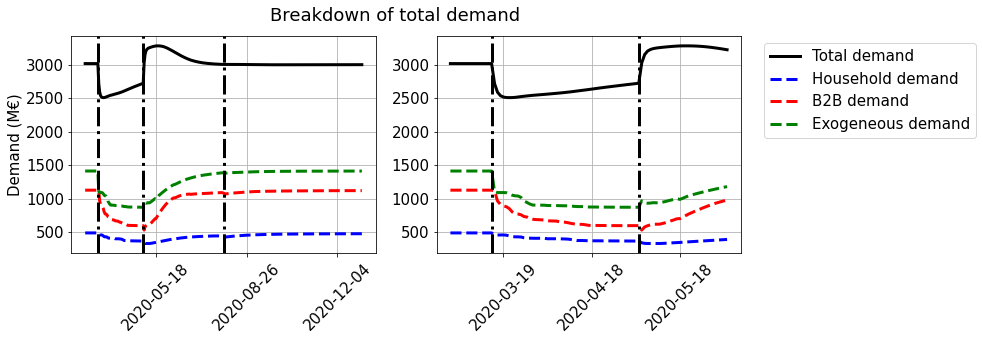

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(out['time'],out['d'].sum(dim='A'),color='black')
ax1.plot(out['time'],out['c'].sum(dim='A'),color='blue',ls='--')
ax1.plot(out['time'],out['O'].sum(dim='A'),color='red',ls='--')
ax1.plot(out['time'],out['f'].sum(dim='A'),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['d'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='black')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['c'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='blue',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['O'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='red',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['f'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Total demand','Household demand','B2B demand','Exogeneous demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid('on')

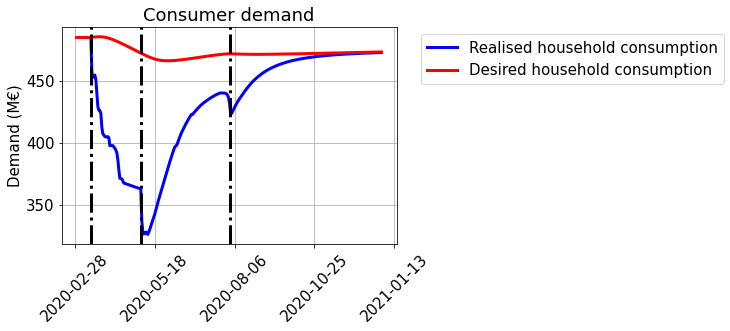

In [12]:
fig,ax=plt.subplots()
ax.plot(out['time'],out['c'].sum(dim='A'),color='blue')
ax.plot(out['time'],out['c_desired'].sum(dim='A'),color='red')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Demand (M€)')
lgd=ax.legend(['Realised household consumption','Desired household consumption'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')

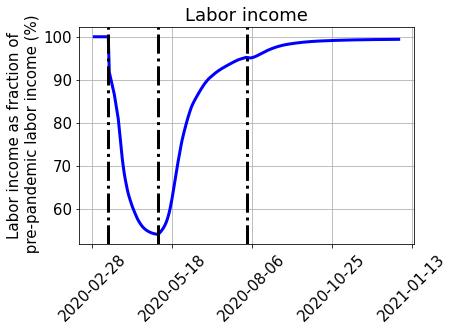

In [13]:
fig,ax=plt.subplots()
ax.plot(out['time'],(out['l'].sum(dim='A')/np.sum(params['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid('on')

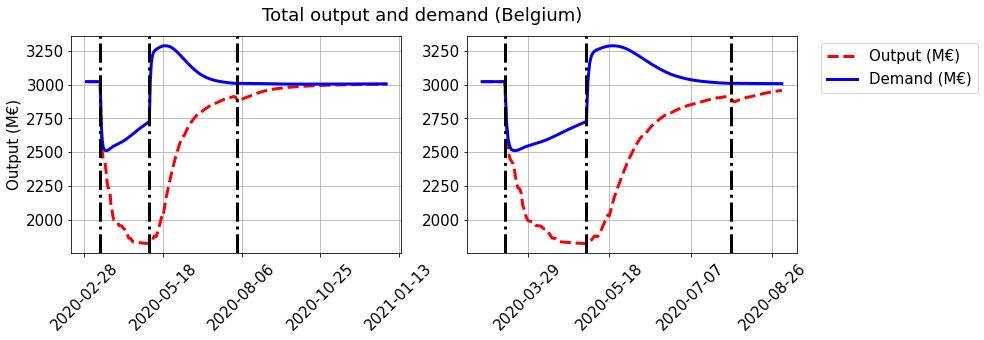

In [14]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(13,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(out['time'],out['x'].sum(dim='A'),color='red',ls='--')
ax1.plot(out['time'],out['d'].sum(dim='A'),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_ylabel('Output (M€)')
ax1.grid('on')

ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),out['x'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),color='red',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),out['d'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_pandemic,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.grid('on')

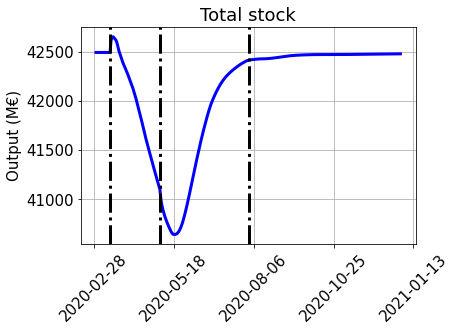

In [15]:
fig,ax=plt.subplots()
ax.plot(out['time'],out['S'].sum(dim='A').sum(dim='A'),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Output (M€)')
ax.grid('on')